# 🛣️ Developing a product similarity model from product text
In this notebook, I will find products that are similar based on their text.

I will be leveraging data from `.csv`.

Data taken from : CPG distributor public site.

In [1]:
from transformers import DistilBertTokenizer, DistilBertForMaskedLM, Trainer, TrainingArguments, AutoTokenizer, DistilBertModel, PreTrainedTokenizer
import pandas as pd
from datasets import Dataset, DatasetDict
import faiss
import torch, numpy as np, random, os, sys


In [2]:
# import custom functions
project_path = os.path.abspath(os.path.join('..', 'src'))
if project_path not in sys.path:
    sys.path.append(project_path)
    
from data.etl import datafile_path_finder, find_nan, TextCleaner
from model.transformers import TokenizerProcessorMLM, get_embedding

## Process Outline

1. Loading data and setting up datasets for training
2. Training (or fine-tuning) the model with `transformers`
3. Evaluating embeddings
4. Applying embeddings to data and find similar products


# 1. Load the data

In [9]:
dir_df = datafile_path_finder('products.csv')
df = pd.read_csv(dir_df)
df = df[['HowTo']]

# 2. Validate the data

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3743 entries, 0 to 3742
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   HowTo   2742 non-null   object
dtypes: object(1)
memory usage: 29.4+ KB


# 3. Clean up the data

In [11]:
find_nan(df)

HowTo    1001
dtype: int64

In [12]:
# Clean up the data
df = df.dropna()
df.shape

(2742, 1)

In [13]:
cleaner = TextCleaner(additional_stopwords=[''])

df['text'] = df['HowTo'].apply(cleaner.clean)

In [14]:
df = df.drop_duplicates(subset='text')
# Reset index of the DataFrame due to dropped rows
df.reset_index(drop=True, inplace=True)

In [9]:
df.to_csv(datafile_path_finder('')+'products_cleaned.csv', index=False)

# 4. Create new features

### Tokenizing the Data
For tokenizing data in NLP, we need to adapt our approach, especially when fine-tuning a pre-existing model like DistilBERT. Here’s why:

- Pre-Established Vocabulary: The model we’re fine-tuning comes with its own predefined vocabulary. Unlike standard methods like CountVectorizer, we don’t add to this vocabulary but work within its limits. Adding new words or emojis isn’t typically necessary unless it's for something specific like social media. For general tasks, using a model already trained on similar data suffices.

- Attention Mechanism: Transformers, like DistilBERT, rely on capturing the sequence of tokens to understand context. Therefore, our tokenizer needs to handle this sequential information effectively.

We’ll use DistilBERT, a streamlined version of BERT with 67 million parameters. The specific model we’ll use is [distilbert-base-uncased](https://huggingface.co/distilbert/distilbert-base-uncased), which is fine-tuned for sentiment analysis in English.

Next, we need to use this `tokenizer` to format our data. I will follow Huggingface's recommended approach.

1. Write a function that accepts each record and returns tokenized data.
2. Use __[`map`](https://huggingface.co/docs/datasets/process)__ to apply that function to our formatted datasets.

In [10]:
pretrained_model = 'distilbert-base-uncased'
tokenizer = DistilBertTokenizer.from_pretrained(pretrained_model)
model = DistilBertForMaskedLM.from_pretrained(pretrained_model)

c:\Users\Forcessofnature\miniconda3\envs\gpu_torch\lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [11]:
# create dataset from the DataFrame
dataset = Dataset.from_pandas(df[['text']])


tokenizer_processor = TokenizerProcessorMLM(tokenizer, max_length=512, mask_probability=0.15)

# Apply the preprocessing function
tokenized_dataset = dataset.map(tokenizer_processor, batched=True)


Map:   0%|          | 0/2303 [00:00<?, ? examples/s]

In [12]:
tokenized_dataset[0]

{'text': 'massage 10 miracle coily hydrating shampoo hair gently fingers product lather richly without extra agitation rinse roots tip gently wring excess water wrap towel without rough towel drying lock shine reduce frizz breakage air dry style usual',
 'input_ids': [101,
  103,
  103,
  9727,
  17085,
  2100,
  26018,
  103,
  25850,
  24667,
  2606,
  5251,
  3093,
  4031,
  2474,
  12399,
  26502,
  103,
  4469,
  22356,
  15544,
  12325,
  6147,
  5955,
  103,
  23277,
  2075,
  9987,
  2300,
  10236,
  10257,
  2302,
  5931,
  10257,
  17462,
  103,
  103,
  5547,
  103,
  10993,
  2480,
  3338,
  4270,
  2250,
  4318,
  2806,
  5156,
  102,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,

# 6. Train the model

Fine tuned the model
 - Check if GPU is been used (recommended)

In [13]:
if torch.cuda.is_available():
    print(f"CUDA is available. GPU name: {torch.cuda.get_device_name(0)}")
else:
    print("CUDA is not available.")


CUDA is available. GPU name: NVIDIA GeForce RTX 3050 Laptop GPU


In [15]:
outdir = "./trained_model"
logdir = "./logs"
for d in [outdir,logdir]:
    os.makedirs(d,exist_ok=True)

In [30]:
training_args =TrainingArguments(output_dir = outdir,
                           overwrite_output_dir = 'True',
                           learning_rate=1e-5,
                           weight_decay=0.001,
                           warmup_steps = 5,
                           num_train_epochs=5,
                           logging_dir=logdir,
                           per_device_train_batch_size=16,
                           prediction_loss_only=True)

In [31]:
# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset,
    # eval_dataset=eval_dataset,
)

# Fine-tune the model
trainer.train()

  0%|          | 0/720 [00:00<?, ?it/s]

{'loss': 1.0296, 'grad_norm': 0.24267800152301788, 'learning_rate': 3.0769230769230774e-06, 'epoch': 3.47}
{'train_runtime': 6780.2129, 'train_samples_per_second': 1.698, 'train_steps_per_second': 0.106, 'train_loss': 0.7300873941845364, 'epoch': 5.0}


TrainOutput(global_step=720, training_loss=0.7300873941845364, metrics={'train_runtime': 6780.2129, 'train_samples_per_second': 1.698, 'train_steps_per_second': 0.106, 'total_flos': 1526441712445440.0, 'train_loss': 0.7300873941845364, 'epoch': 5.0})

In [32]:
# Save the fine-tuned model
model.save_pretrained('fine-tuned-distilbert_gpu')


## 3. Embeddings

In [3]:

# Load the pre-trained model and tokenizer
pretrained_model = 'distilbert-base-uncased'
tokenizer = DistilBertTokenizer.from_pretrained(pretrained_model)
model = DistilBertModel.from_pretrained('trained_model/checkpoint-720')

c:\Users\Forcessofnature\miniconda3\envs\gpu_torch\lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [5]:
# Move the model to the device
model = model.to(device)

In [16]:
# Apply the function to the DataFrame and compute embeddings
df['embedding'] = df['text'].apply(lambda x: get_embedding(x, tokenizer, model, device=device))
df.to_csv(datafile_path_finder('')+'products_embeddings.csv', index=False)

# Convert embeddings to a numpy array and save
embeddings = np.stack(df['embedding'].values)
np.save('embeddings.npy', embeddings)


In [17]:
embeddings.shape

(2303, 768)

In [18]:
df.head(3)

,HowTo,text,embedding
0,Massage It’s a 10 Miracle Coily Hydrating Sham...,massage 10 miracle coily hydrating shampoo hai...,"[0.3226863, 0.43503103, 0.09806985, -0.1297985..."
1,• For best results use at least twice a week o...,best results use least twice week directed phy...,"[0.5035795, 0.45232636, 0.15499322, -0.1866919..."
2,1. After treating with Smoothing Mousse or Dam...,1 treating smoothing mousse damage recovery an...,"[0.04409787, 0.3435498, 0.049628194, -0.208050..."


### Change eviroments to find the product similarities

Due to dependance in enviroments it best to use CPU for this step if using Windows PC.

In [1]:
import pandas as pd
import numpy as np
import faiss
import os, sys

# import custom functions
project_path = os.path.abspath(os.path.join('..', 'src'))
if project_path not in sys.path:
    sys.path.append(project_path)
    
from data.etl import datafile_path_finder, find_nan, TextCleaner
from model.transformers import TokenizerProcessorMLM, get_embedding

In [3]:
df = pd.read_csv(datafile_path_finder('')+'products_embeddings.csv')

In [4]:
# Load embeddings from file
loaded_embeddings = np.load('embeddings.npy')

# Dimension of embeddings
d = loaded_embeddings.shape[1]

In [5]:
# Create a FAISS index
index = faiss.IndexFlatL2(d)  # Using L2 distance for similarity

# Add embeddings to the index
index.add(loaded_embeddings)

# k specifies the number of nearest neighbors to find (k=2 to find the closest match excluding itself)
k = 3

# Perform the search
D, I = index.search(loaded_embeddings, k)  # D = distances, I = indices of nearest neighbors

# Create DataFrame columns for nearest neighbors and distances
df['nearest_neighbor_1'] = [df['text'][i[1]] if len(i) > 1 else "None" for i in I]
df['nearest_neighbor_1_distance'] = [d[1] if len(d) > 1 else "None" for d in D]
df['nearest_neighbor_2'] = [df['text'][i[2]] if len(i) > 2 else None for i in I]
df['nearest_neighbor_2_distance'] = [d[2] if len(d) > 2 else None for d in D]
df.drop(columns=['embedding'], inplace=True)



In [6]:
df.to_csv(datafile_path_finder('')+'products_simimilarity.csv', index=False)

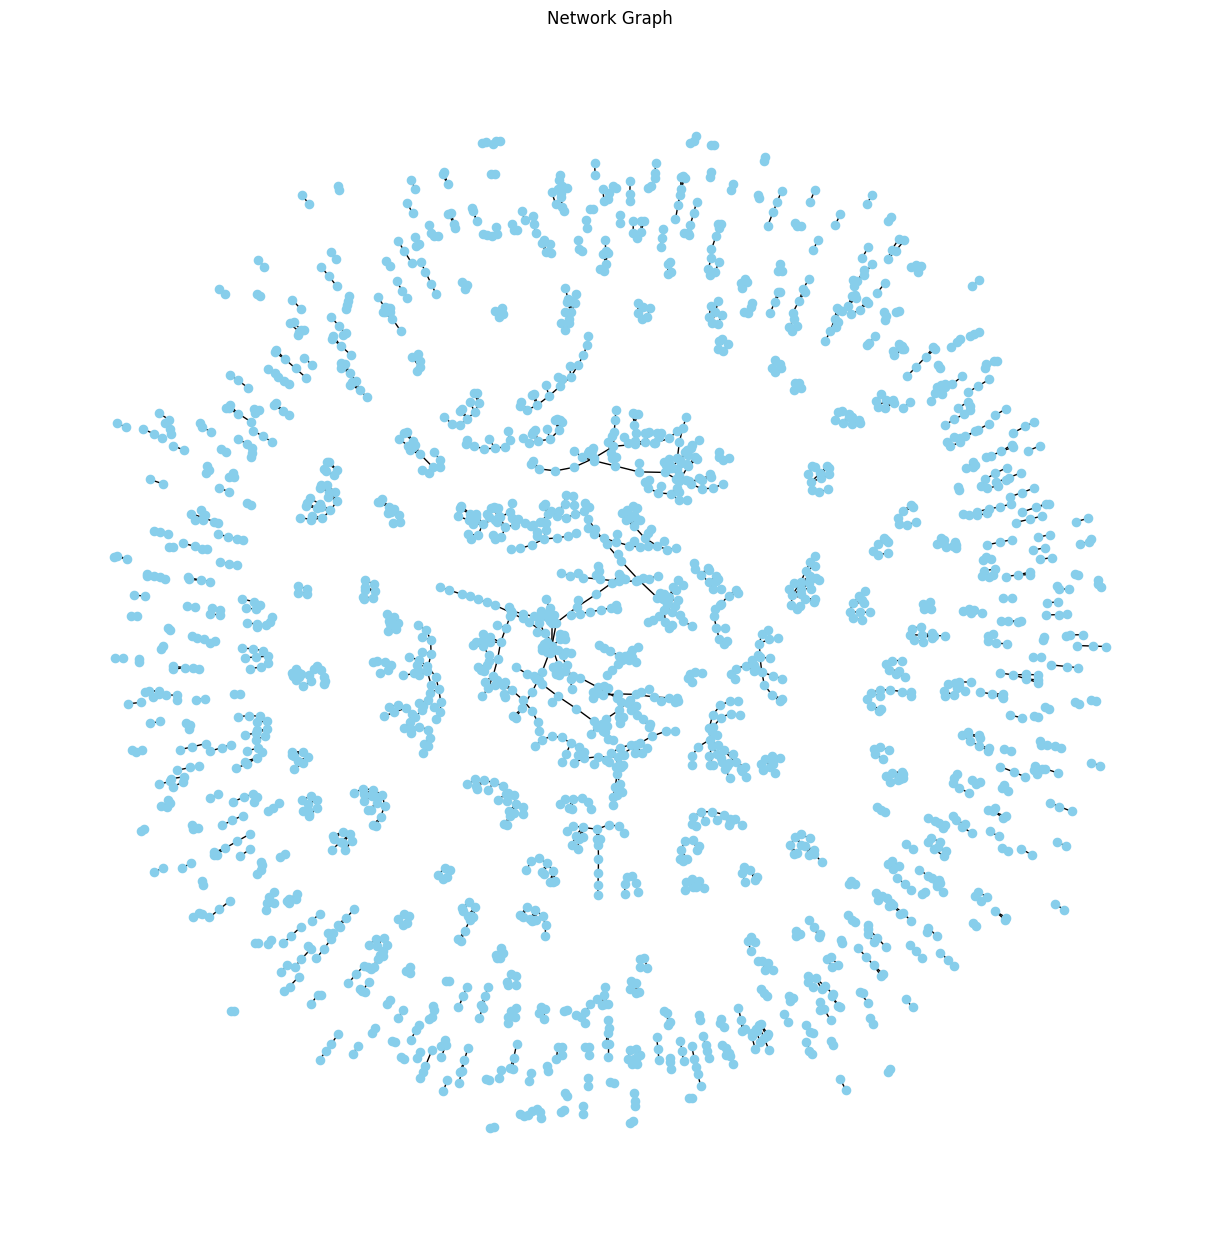

In [9]:
import networkx as nx
import matplotlib.pyplot as plt

G = nx.Graph()

# Add edges to the graph
for index, row in df.iterrows():
    G.add_edge(row['text'], row['nearest_neighbor_1'])

# Draw the network
plt.figure(figsize=(12, 12))  # Optional: adjust figure size
pos = nx.spring_layout(G)  # Layout algorithm for positioning nodes
nx.draw(G, pos, with_labels=False, node_color='skyblue', node_size=35, edge_color='black')
plt.title('Network Graph')
plt.show()

In [ ]:
# After fine tuning the model, the results are top 2 products that are similar to the given product based on their product descriptions.


Text based product descriptions are 